Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Spring 2020

### Setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# modify to where you store your project data including utils
datadir = "/content/drive/MyDrive/mp5/" 

utilfn = datadir + "utils.py"
!cp "$utilfn" .
imagesfn = datadir + "images"
!cp -r "$imagesfn" .

In [3]:
!pip uninstall opencv-python -y
# downgrade OpenCV a bit to use SIFT
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall
!pip install ffmpeg-python # for converting to video

import ffmpeg
import cv2
import numpy as np
import os
from numpy.linalg import svd, inv
import utils
%matplotlib inline
from matplotlib import pyplot as plt

  Using cached https://files.pythonhosted.org/packages/61/29/fc60b2de1713aa92946992544329f20ccb5e4ba26290f403e04b7da44105/opencv_contrib_python-3.4.2.17-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/87/86/753182c9085ba4936c0076269a571613387cdb77ae2bf537448bfd63472c/numpy-1.19.4-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.4 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.

### Part I: Stitch two key frames 

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.

Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image.

In [4]:
def score_projection2(pt1, pt2):
  '''
  Score corresponding to the number of inliers for RANSAC
  Input: pt1 and pt2 are 2xN arrays of N points such that pt1[:, i] and pt2[:,i] should be close in Euclidean distance if they are inliers
  Outputs: score (scalar count of inliers) and inliers (1xN logical array)
  '''

  thresh = 0.6
  _, N = pt1.shape
  inliers = []
  score = 0

  for i in range(N):
    min1 = 99999999999999
    min2 = 99999999999999
    for j in range(N):
      dist = np.linalg.norm(pt1[:, i] - pt2[:, j])
      if dist < min1:
        min1 = dist
      elif dist < min2:
        min2 = dist
    
    if (min1/min2) <= thresh:
      # print(min1, min2, min1/min2)
      inliers.append(True)
      score += 1
    else:
      inliers.append(False)

  #print(score, inliers)
  return score, inliers

def score_projection(pt1, pt2):
  thresh = 3.5
  dists = np.linalg.norm(pt1 - pt2, axis=0)
  inliers = np.where(dists < thresh, True, False)

  return np.sum(inliers), inliers


def auto_homography(Ia,Ib, homography_func=None,normalization_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0
    n_to_sample = 6 # Put the correct number of points here


    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, n_to_sample, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2, normalization_func) # edit helper code below (computeHomography)

        
        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        
        score_t, inliers_t = score_projection(Xb[:2,:]/Xb[2,:], Xb_[:2,:]/Xb_[2,:])


        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = inliers_t

            # print(best_score)

            # if best_score > 350:
            #   break
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers


    return H

In [5]:
def computeHomography(pts1, pts2,normalization_func=None):
    '''
    Compute homography that maps from pts1 to pts2 using SVD. Normalization is optional.
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    # TO DO
    _, N = pts1.shape

    A = np.zeros((N*2, 9))
    c = 0

    for i in range(N):
      u, v, w = pts1[0, i]/pts1[2, i], pts1[1, i]/pts1[2, i], pts1[2, i]
      u_, v_, w_ = pts2[0, i]/pts2[2, i], pts2[1, i]/pts2[2, i], pts2[2, i]

      A[c, 0] = -u
      A[c, 1] = -v
      A[c, 2] = -1
      A[c, 6] = u*u_
      A[c, 7] = v*u_
      A[c, 8] = u_

      c += 1

      A[c, 3] = -u
      A[c, 4] = -v
      A[c, 5] = -1 
      A[c, 6] = u*v_ 
      A[c, 7] = v*v_
      A[c, 8] = v_

      c += 1
    
    [U, S, Vh] = np.linalg.svd(A)
    x = Vh[-1, :]

    H = np.zeros((3, 3))

    for i in range(len(x)):
      H[int(i/3), i%3] = x[i]

    return H



    



best score: 220.000000
[[ 1.00000000e+00  3.54747420e-02 -2.03265423e+02]
 [ 8.97851143e-03  9.34459882e-01 -1.27141358e+01]
 [ 3.54031235e-04 -3.31491715e-06  8.29984222e-01]]


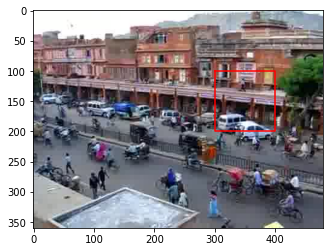

In [6]:
# images location
im1 = './images/input/frames/f0270.jpg'
im2 = './images/input/frames/f0450.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1).astype(np.uint8)
im2 = cv2.imread(im2).astype(np.uint8)

H = auto_homography(im1,im2, computeHomography)
print(H/H.max()) 

# plot the frames here
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
f = plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

# TO DO: project points into im2 and display the projected lines on im2



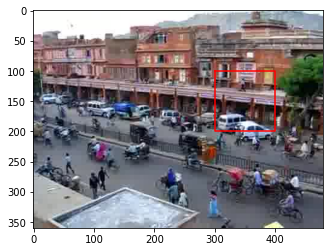

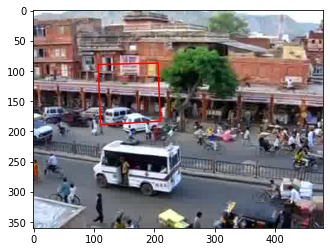

In [7]:
box_pts = np.array([[300, 400, 400, 300, 300], [100, 100, 200, 200, 100], [1, 1, 1, 1, 1]])
f = plt.figure()
plt.imshow(im1[:,:,[2,1,0]])
plt.plot(box_pts[0,:], box_pts[1, :], 'r-')

f.savefig("red_box_1.svg", format='svg', dpi=1200)

second_pts = np.dot(H, box_pts)
second_pts /= second_pts[2]

f = plt.figure()
plt.imshow(im2[:,:,[2,1,0]])
plt.plot(second_pts[0,:], second_pts[1, :], 'r-')

f.savefig("red_box_2.svg", format='svg', dpi=1200)


[[ 4.90992836e-03  1.74178442e-04 -9.98018667e-01]
 [ 4.40838479e-05  4.58813108e-03 -6.24254958e-02]
 [ 1.73826800e-06 -1.62760057e-08  4.07516307e-03]]
[[ 6.0571851e-03  1.6343629e-04  1.6915890e+00]
 [ 2.5267602e-04  4.5861779e-03  4.2659408e-01]
 [ 1.7382680e-06 -1.6276006e-08  4.0751630e-03]]


True

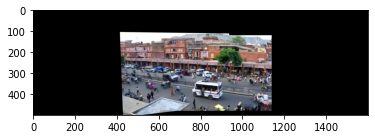

In [8]:
projectedWidth = 1600
projectedHeight = 500
T1 = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]).astype(np.float32)
T2 = np.dot(T1, H)
print(H)
T2 = T2.astype(np.float32)
print(T2)
# TO DO: warp and blend the two images
projIm1 = cv2.warpPerspective(im1, T2, (projectedWidth, projectedHeight))
projIm2 = cv2.warpPerspective(im2, T1, (projectedWidth, projectedHeight))
blendOut = utils.blendImages(projIm1, projIm2) 

f = plt.figure()
plt.imshow(blendOut[:,:,[2,1,0]])

f.savefig("two_frame_blend.svg", format='svg', dpi=1200)
cv2.imwrite("two_frame_blend.jpg", blendOut)

### Part II: Panorama using five key frames

Produce a panorama by mapping five key frames [90, 270, 450, 630, 810] onto the same reference frame 450.  


In [9]:
key_frames_idx = np.array([90, 270, 450, 630, 810])-1

frames = np.zeros((len(key_frames_idx), im1.shape[0], im1.shape[1], im1.shape[2]),dtype='uint8')
for n in range(len(frames)):
  frames[n] = cv2.imread("./images/input/frames/f0{num}.jpg".format(num=str(key_frames_idx[n]+1).zfill(3))).astype(np.uint8)

# TO DO solution

im_ref = im2

H_list = []

for i in range(len(frames)):
  if key_frames_idx[i] == 449:
    H_list.append(np.identity(3))
    continue
  if key_frames_idx[i] == 89:
    H1_temp = auto_homography(frames[i], frames[i+1], computeHomography)
    H_list.append(H1_temp)
    continue
  if key_frames_idx[i] == 809:
    H1_temp = auto_homography(frames[i], frames[i-1], computeHomography)
    H_list.append(H1_temp)
    continue
  
  H_new = auto_homography(frames[i],im2, computeHomography)
  print(H_new/H_new.max()) 

  H_list.append(H_new)

H_list = np.array(H_list)
print(H_list)


best score: 256.000000
best score: 218.000000
[[ 1.00000000e+00  2.91219334e-02 -2.02722378e+02]
 [ 9.52841575e-03  9.43116110e-01 -1.31368715e+01]
 [ 3.40693782e-04  4.04785582e-05  8.27266599e-01]]
best score: 214.000000
[[-2.04702641e+01  1.00000000e+00 -3.62717899e+03]
 [ 3.14518776e-01 -2.26015417e+01 -4.62963792e+02]
 [ 7.22474797e-03  2.51010847e-04 -2.40335961e+01]]
best score: 150.000000
[[[ 5.32402036e-03  2.88039420e-04 -9.95047820e-01]
  [-7.15823250e-05  5.08406741e-03 -9.90217561e-02]
  [ 1.69387164e-06  8.66656152e-08  4.49966313e-03]]

 [[ 4.92237612e-03  1.43349110e-04 -9.97875794e-01]
  [ 4.69024461e-05  4.64237222e-03 -6.46646226e-02]
  [ 1.67702294e-06  1.99250688e-07  4.07211735e-03]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[-5.59784480e-03  2.73462266e-04 -9.91896585e-01]
  [ 8.60090172e-05 -6.18066880e-03 -1.26603128e-01]
  [ 1.97569595e-06  6.

In [10]:
# for i in range(len(frames)):
#   plt.figure()
#   plt.imshow(frames[i])

H4 = auto_homography(frames[4], frames[3], computeHomography)

best score: 150.000000


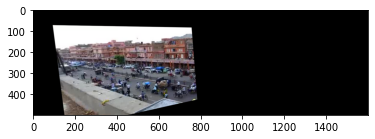

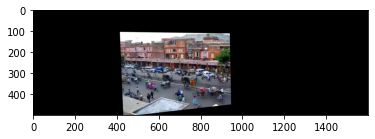

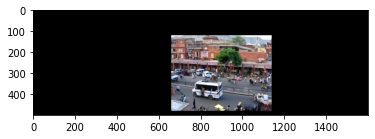

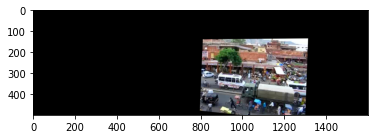

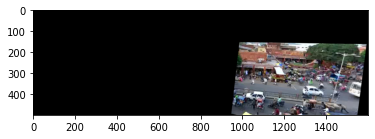

In [11]:
proj_ims = []


for n in range(len(frames)):
  if n == 0:
    Trans = np.dot(T1, np.dot(H_list[n+1], H_list[n]))

  elif n == 4:
    Trans = np.dot(T1, np.dot(H_list[n-1], H_list[n]))

  else:
    Trans = np.dot(T1, H_list[n]) # transformation that maps nth frame onto centered reference

  projIm =cv2.warpPerspective(frames[n], Trans, (projectedWidth, projectedHeight))

  proj_ims.append(projIm)

  plt.figure()

  plt.imshow(projIm[:,:,[2,1,0]])

True

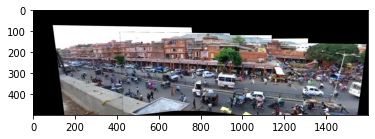

In [12]:
blend_out = proj_ims[0]

for i in range(1, len(proj_ims)):
  blend_out = utils.blendImages(blend_out, proj_ims[i])

f = plt.figure()
plt.imshow(blend_out[:,:,[2,1,0]])

f.savefig("panorama.svg", format='svg', dpi=1200)

cv2.imwrite("panorama.jpg", blend_out)

### Part 3: Map the video to the reference plane

Project each frame onto the reference frame (using same size panorama) to create a video that shows the portion of the panorama revealed by each frame

In [13]:
# read all the images
import os 
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype='uint8')

for idx, file_i in enumerate(filenames):
  frames[idx] = cv2.imread(file_i)



In [14]:
# TO DO part 3 solution
N = len(frames)

keys = np.array([90, 270, 450, 630, 810]) - 1
keys = list(keys)

H_all = np.zeros((N, 3, 3))

for i in range(N):
  if i in keys:
    print("using precomputed H", i)
    H_all[i] = H_list[keys.index(i)]

  elif i < keys[0] + 90:
    print("using keys[0]", i)
    H_temp = auto_homography(frames[i], frames[keys[0]], computeHomography)
    H_all[i] = np.dot(H_list[1], np.dot(H_list[0], H_temp))
  
  elif i < keys[1] + 90:
    print("using keys[1]", i)
    H_temp = auto_homography(frames[i], frames[keys[1]], computeHomography)
    H_all[i] = np.dot(H_list[1], H_temp)

  elif i > keys[4] - 90:
    print("using keys[4]", i)
    H_temp = auto_homography(frames[i], frames[keys[4]], computeHomography)
    H_all[i] = np.dot(H_list[3], np.dot(H_list[4], H_temp))

  elif i > keys[3] - 90:
    print("using keys[3]", i)
    H_temp = auto_homography(frames[i], frames[keys[3]], computeHomography)
    H_all[i] = np.dot(H_list[3], H_temp) 

  else:
    print("mapping straight to ref", i)
    H_all[i] = auto_homography(frames[i], im_ref, computeHomography)

np.save("H_all.npy", H_all) 

# create your video (see tips)

using keys[0] 0
best score: 428.000000
using keys[0] 1
best score: 428.000000
using keys[0] 2
best score: 451.000000
using keys[0] 3
best score: 441.000000
using keys[0] 4
best score: 461.000000
using keys[0] 5
best score: 450.000000
using keys[0] 6
best score: 481.000000
using keys[0] 7
best score: 458.000000
using keys[0] 8
best score: 476.000000
using keys[0] 9
best score: 495.000000
using keys[0] 10
best score: 494.000000
using keys[0] 11
best score: 479.000000
using keys[0] 12
best score: 494.000000
using keys[0] 13
best score: 478.000000
using keys[0] 14
best score: 508.000000
using keys[0] 15
best score: 505.000000
using keys[0] 16
best score: 516.000000
using keys[0] 17
best score: 507.000000
using keys[0] 18
best score: 490.000000
using keys[0] 19
best score: 495.000000
using keys[0] 20
best score: 480.000000
using keys[0] 21
best score: 491.000000
using keys[0] 22
best score: 504.000000
using keys[0] 23
best score: 493.000000
using keys[0] 24
best score: 518.000000
using keys

In [15]:
ims_final = []

N = len(frames)
T1 = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]).astype(np.float32)


H_all = np.load("H_all.npy") 


for i in range(0, N):
  Trans = np.dot(T1, H_all[i])
  ims_final.append(cv2.warpPerspective(frames[i], Trans, (projectedWidth, projectedHeight)))

ims_final = np.array(ims_final)
utils.vidwrite_from_numpy("fnout.mp4", ims_final[:,:,:,[2,1,0]], framerate=30)



In [16]:
np.save("ims_final.npy", ims_final) 

# plt.figure()
# plt.imshow(ims_final[199, :, :, ])
# cv2.imwrite("frame200.jpg", ims_final[199])

### Part 4: Create background panorama

Create a background panorama based on the result from Part 3.


In [17]:
# TO DO part 4

N, h, w, _ = ims_final.shape
tol = 1e-3
black = np.zeros(3)

bg_im = np.zeros(ims_final[0].shape)

sum_arr = np.sum(ims_final, axis=0)
sum_again = np.sum(sum_arr, axis = 2)

mask = np.where(sum_again != 0, 1, 0)





In [18]:
count = 0

for i in range(h):
  print(i)
  for j in range(w):
    if mask[i, j] == 0:
      continue
    vecs = ims_final[:,i, j]
    sum_vec = np.sum(vecs, axis=1)
    nonzeros = np.argwhere(sum_vec != 0).T[0]
    # bg_im[i, j] = np.median(, axis=0)
    count += 1
    count_dict = {}
    for v in vecs[nonzeros]:
      count_dict[tuple(v)] = count_dict.get(tuple(v), 0) + 1
    # print(count_dictcount_dict)
    bg_im[i, j] = np.asarray(max(count_dict, key=lambda key: count_dict[key]))

    
print(count)
    

plt.figure()
plt.imshow(bg_im[:,:,[2, 1, 0]])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123


KeyboardInterrupt: ignored

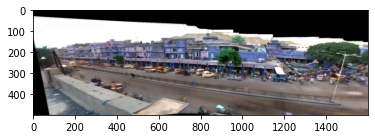

In [19]:
# bg_im = bg_im.astype(np.uint8)

# plt.figure()
# plt.imshow(bg_im)

# cv2.imwrite("bg_im.jpg", bg_im)
bg_im=cv2.imread("bg_im.jpg")
ex_frame = cv2.imread("images/input/frames/f0001.jpg")
H_all = np.load("H_all.npy")
T1 = np.array([[1, 0, 660], [0, 1, 120], [0, 0, 1]]).astype(np.float32)
plt.figure()
plt.imshow(bg_im)

### Part 5: Create background movie

Generate a movie that looks like the input movie but shows only background pixels. For each frame of the movie, you need to estimate a projection from the panorama to that frame. Your solution can use the background image you created in Part 4 and the per-frame homographies you created in Part 3. 


In [20]:
# TO DO part 5
N = 900
h, w, c= ex_frame.shape
bg_vid = np.zeros((N, h, int(w), c))
for i in range(N):
  currH = np.dot(T1, H_all[i])
  bg_vid[i] = cv2.warpPerspective(bg_im, np.linalg.inv(currH), (int(w), h))

utils.vidwrite_from_numpy("bgout.mp4", bg_vid[:, :, :, [2,1,0]], framerate=30)

In [21]:
cv2.imwrite("bg_frame200.jpg", bg_vid[199])

True

In [ ]:
for i in range(N):
  bg_vid[i][:, :int(w)] = frames[i]

utils.vidwrite_from_numpy("hm.mp4", bg_vid[:,:,:,[2,1,0]], framerate=30)

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that emphasizes or includes only foreground pixels.

In [22]:
# TO DO part 6
for i in range(N):
  currH = np.dot(T1, H_all[i])
  frames[i] = cv2.warpPerspective(ims_final[i], np.linalg.inv(currH), (w, h))

# utils.vidwrite_from_numpy("crapy_recreation.mp4", frames[:,:,:,[2,1,0]], framerate=30)

(900, 360, 480, 3) [254. 254. 254.]


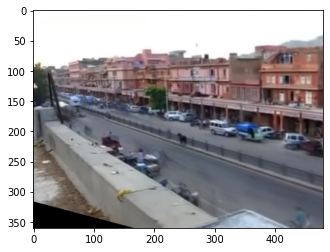

In [23]:
print(bg_vid.shape, bg_vid[0, 0, 0])
bg_vid = bg_vid.astype(np.uint8)

plt.imshow(cv2.cvtColor(bg_vid[0], cv2.COLOR_BGR2RGB))
fg_vid = np.copy(frames)

In [24]:
bg_vid = np.array([cv2.cvtColor(bg_vid[i], cv2.COLOR_BGR2LAB) for i in range(N)])
print(bg_vid.shape, frames[i].astype(float).shape)
fg_vid = np.array([cv2.cvtColor(fg_vid[i], cv2.COLOR_BGR2LAB) for i in range(N)])


(900, 360, 480, 3) (360, 480, 3)


[  0 128 128] [  0 128 128]


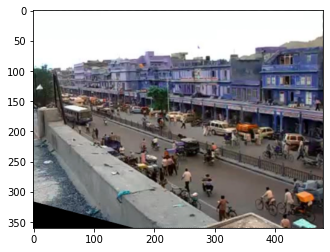

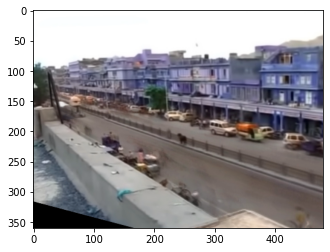

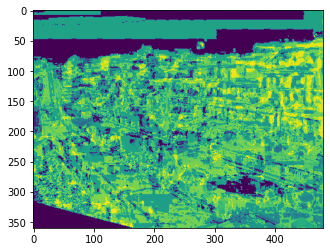

In [25]:
plt.figure()
plt.imshow(cv2.cvtColor(fg_vid[0] , cv2.COLOR_LAB2BGR))
plt.figure()

plt.imshow(cv2.cvtColor(bg_vid[0], cv2.COLOR_LAB2BGR))

plt.figure()
plt.imshow(np.linalg.norm(fg_vid[0] - bg_vid[0], axis=2))

print(bg_vid[0][359, 0], fg_vid[0][359, 0])

In [26]:
tol = 260
fg_vid_final = np.copy(fg_vid)

for i in range(N):
  # print(frames[i])
  dists = np.linalg.norm((fg_vid[i] - bg_vid[i]).reshape((w*h, c)), axis=1).reshape(h,w)
  dists = np.argwhere(dists < tol)
  # print(bg_vid[i])
  # print(dists)
  # print(fg_vid.shape)
  for elem in dists:
    fg_vid_final[i, elem[0], elem[1]] = np.array([0, 128, 128])
  
  # if i == 5:
  #   break
  # plt.figure()
  # plt.imshow(cv2.cvtColor(fg_vid_final[i], cv2.COLOR_LAB2RGB))




In [32]:
# count = 0
# for i in range(N):
  
#   fg_vid_final[i] = cv2.cvtColor(fg_vid_final[i], cv2.COLOR_LAB2RGB)

utils.vidwrite_from_numpy("trash_fg_vid.mp4", fg_vid_final[:,:,:,[2,1,0]], framerate=30)

In [31]:
cv2.imwrite("trash_fg_200.jpg", fg_vid_final[199][:,:,[2,1,0]])

True

## Bells and whistles